<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Пропуски-и-дубликаты" data-toc-modified-id="Пропуски-и-дубликаты-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Пропуски и дубликаты</a></span></li><li><span><a href="#Функции-подбора" data-toc-modified-id="Функции-подбора-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Функции подбора</a></span></li><li><span><a href="#Исходные-данные" data-toc-modified-id="Исходные-данные-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исходные данные</a></span></li><li><span><a href="#Умножение-на-обратимую-матрицу" data-toc-modified-id="Умножение-на-обратимую-матрицу-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Умножение на обратимую матрицу</a></span><ul class="toc-item"><li><span><a href="#Теория" data-toc-modified-id="Теория-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Теория</a></span></li><li><span><a href="#Алгоритм" data-toc-modified-id="Алгоритм-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Алгоритм</a></span></li><li><span><a href="#Реализация" data-toc-modified-id="Реализация-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Реализация</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Защита персональных данных клиентов

Имеются данные клиентов страховой компании, по которым осуществляются предсказания.

Требуется преобразовать их в формат, из которого будет трудно извлечь персональную информацию.

При этом качество моделей машинного обучения упасть не должно.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.ticker import MaxNLocator

import sklearn
from sklearn import metrics, model_selection, preprocessing, tree, linear_model, ensemble
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [2]:
np.random.seed(57)

## Описание данных

In [3]:
try:
    data = pd.read_csv('insurance.csv')
except:
    data = pd.read_csv('/datasets/insurance.csv')

In [4]:
data

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


Здесь целевой признак (страховые выплаты) отражает количество страховых выплат клиенту за последние 5 лет.

In [5]:
data.nunique()

Пол                    2
Возраст               46
Зарплата             524
Члены семьи            7
Страховые выплаты      6
dtype: int64

In [6]:
def barplot_from_counts(series):
    series.index = series.index.map(str)
    legend = []
    for row in range(len(series)):
        legend.append(mpatches.Patch(
            color=plt.colormaps.get_cmap('Set1').colors[row], 
            label='{}: {}'.format(series.index[row], series.iloc[row])))
    fig, ax = plt.subplots()
    plt.bar(x=series.index, 
            height=series.values, 
            color=plt.colormaps.get_cmap('Set1').colors)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(series.name)
    plt.legend(handles=legend)
    plt.show()

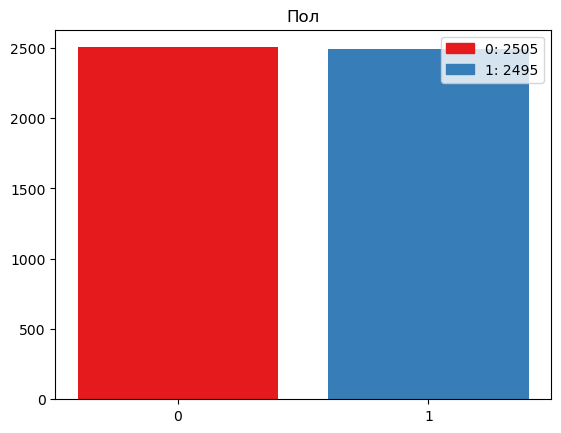

In [7]:
gender = data['Пол'].value_counts()
barplot_from_counts(data['Пол'].value_counts())

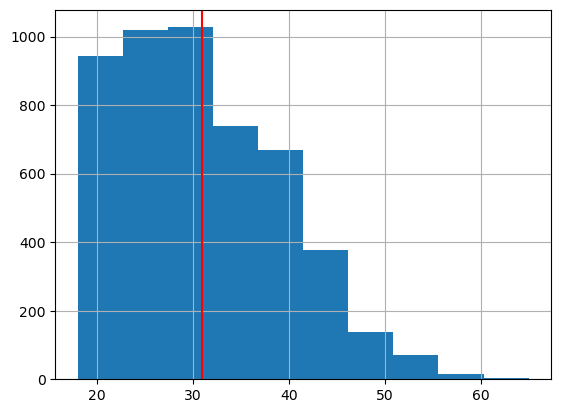

In [8]:
data['Возраст'].hist()
plt.axvline(x=data['Возраст'].mean(), color='red')
plt.show()

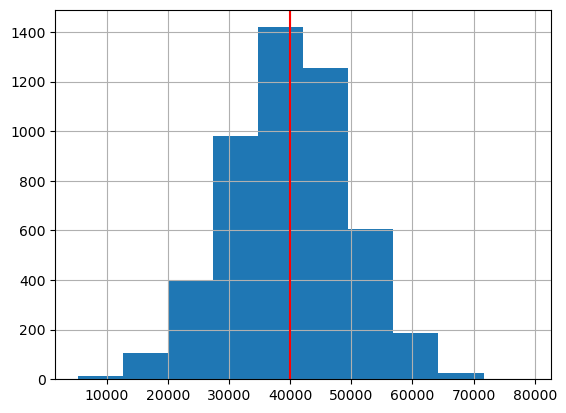

In [9]:
data['Зарплата'].hist()
plt.axvline(x=data['Зарплата'].mean(), color='red')
plt.show()

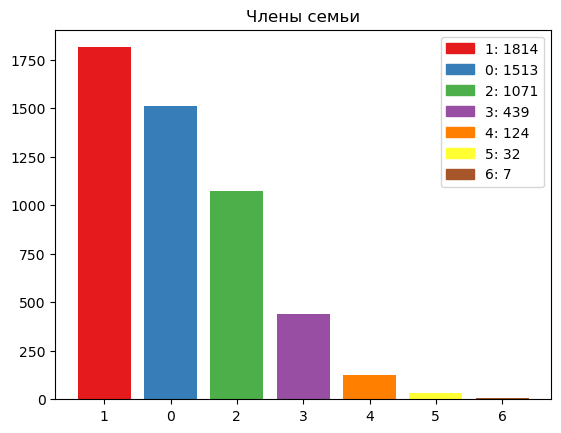

In [10]:
family = data['Члены семьи'].value_counts()
barplot_from_counts(family)

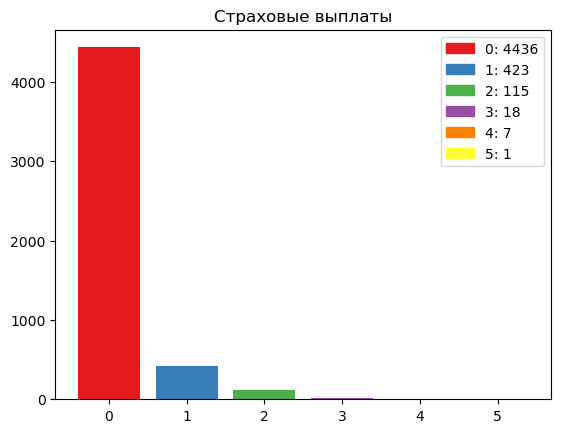

In [11]:
payments = data['Страховые выплаты'].value_counts()
barplot_from_counts(payments)

## Пропуски и дубликаты

In [12]:
data.isna().sum()

Пол                  0
Возраст              0
Зарплата             0
Члены семьи          0
Страховые выплаты    0
dtype: int64

In [13]:
data[data.duplicated()]

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
281,1,39.0,48100.0,1,0
488,1,24.0,32900.0,1,0
513,0,31.0,37400.0,2,0
718,1,22.0,32600.0,1,0
785,0,20.0,35800.0,0,0
...,...,...,...,...,...
4793,1,24.0,37800.0,0,0
4902,1,35.0,38700.0,1,0
4935,1,19.0,32700.0,0,0
4945,1,21.0,45800.0,0,0


In [14]:
data[data['Зарплата'] == 48100.0]

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
69,1,39.0,48100.0,1,0
281,1,39.0,48100.0,1,0
434,1,32.0,48100.0,2,0
717,1,27.0,48100.0,3,0
906,0,27.0,48100.0,0,0
1081,1,42.0,48100.0,0,1
1263,0,44.0,48100.0,0,1
1279,0,44.0,48100.0,3,1
1706,0,29.0,48100.0,3,0
1763,1,29.0,48100.0,2,0


Больше похоже на совпадение, чем на дубликаты.

## Функции подбора

Поскольку задачей является построение выборок, а не обучение, процедуру обучения пропишем функциями.

In [15]:
def test_LinearRegression(features_train, features_test, target_train, target_test):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)
    
    return r2_score(target_test, predictions)

In [16]:
def test_DecisionTreeRegressor(features_train, features_test, target_train, target_test):
    model = DecisionTreeRegressor()
    params = {'max_depth': range(1, 30, 3)}
    tree = GridSearchCV(model, params, cv=10, scoring='r2')
    tree.fit(features_train, target_train)
    predictions = tree.best_estimator_.predict(features_test)
    
    print(tree.best_params_)
    return r2_score(target_test, predictions)

In [17]:
def test_RandomForestRegressor(features_train, features_test, target_train, target_test):
    model = RandomForestRegressor()
    params = {'max_depth': range(1, 30, 7), 'n_estimators': range(1, 202, 50)}
    forest = GridSearchCV(model, params, cv=5, scoring='r2')
    forest.fit(features_train, target_train)
    predictions = forest.best_estimator_.predict(features_test)
    
    # print(np.unique(predictions))
    print(forest.best_params_)
    return r2_score(target_test, predictions)

## Исходные данные

In [18]:
data

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


Получим выборки.

In [19]:
features = data.drop('Страховые выплаты', axis=1)
target = data['Страховые выплаты']

In [20]:
features.head()

,Пол,Возраст,Зарплата,Члены семьи
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0


In [21]:
target.head()

0    0
1    1
2    0
3    0
4    0
Name: Страховые выплаты, dtype: int64

## Умножение на обратимую матрицу

### Теория

Предсказание линейной регрессии $y$ рассчитывается как

$y = (x, w) + w_0 = \sum \limits_{i=1}^{n} w_ix_i + w_0$

где 
- n – число признаков
- x – вектор признаков предсказываемого объекта
- w – вектор коэффициентов линейной регрессии
- w_0 – коэффициент сдвига

$ x = 
\begin{pmatrix}
x_1 \\
x_2 \\
... \\
x_n
\end{pmatrix}, 
w = 
\begin{pmatrix}
w_1 \\
w_2 \\
... \\
w_n
\end{pmatrix}
$

Допустим, в ходе обучения мы предсказываем k объектов. Тогда набор предсказаний k

$
\begin{cases}
y_1 = (x_1, w) + w_0 = \sum \limits_{i=1}^{n} w_{i}x_{1i} + w_0 \\
y_2 = (x_2, w) + w_0 = \sum \limits_{i=1}^{n} w_{i}x_{2i} + w_0 \\
... \\
y_k = (x_k, w) + w_0 = \sum \limits_{i=1}^{n} w_{i}x_{ki} + w_0
\end{cases}
$

можно записать в виде матрицы

$
\begin{pmatrix}
y_1 \\
y_2 \\
... \\
y_k
\end{pmatrix}
 = 
\begin{pmatrix}
x_{11} & x_{12} & ... & x_{1n} \\
x_{21} & x_{22} & ... & x_{2n} \\
... & ... & ... & ...\\
x_{k1} & x_{k2} & ... & x_{kn}
\end{pmatrix}
\begin{pmatrix}
w_1 \\
w_2 \\
... \\
w_n 
\end{pmatrix}
 + 
 \begin{pmatrix}
w_0 \\
w_0 \\
... \\
w_0 
\end{pmatrix}
$

или сокращённо

$y = Xw + w_0$

При обучении вектор весов рассчитывается как

$ 
w = (X^TX)^{-1}X^Ty
$

А в случае умножения на матрицу $P$

$
w_p = ((XP)^TXP)^{-1}(XP)^Ty
$

Если выразить один через другой, то получим

$
w = (X^TX)^{-1}X^Ty \\
w_p = ((XP)^TXP)^{-1}(XP)^Ty = (P^TX^TXP)^{-1}P^TX^Ty = P^{-1}(X^TX)^{-1}(P^T)^{-1}P^TX^Ty = P^{-1}(X^TX)^{-1}EX^Ty = P^{-1}(X^TX)^{-1}X^Ty = P^{-1}w
$

Поскольку предсказания рассчитываются как $y = Xw + w_0$, то для обучения на обновлённых признаках получаем, что 

$y_p = XPw_p + w_0 = XPP^{-1}w + w_0 = XEw + w_0 = Xw + w_0 = y$.

То есть по идее качество не поменяется.

### Алгоритм

Таким образом, алгоритм преобразования следующий:

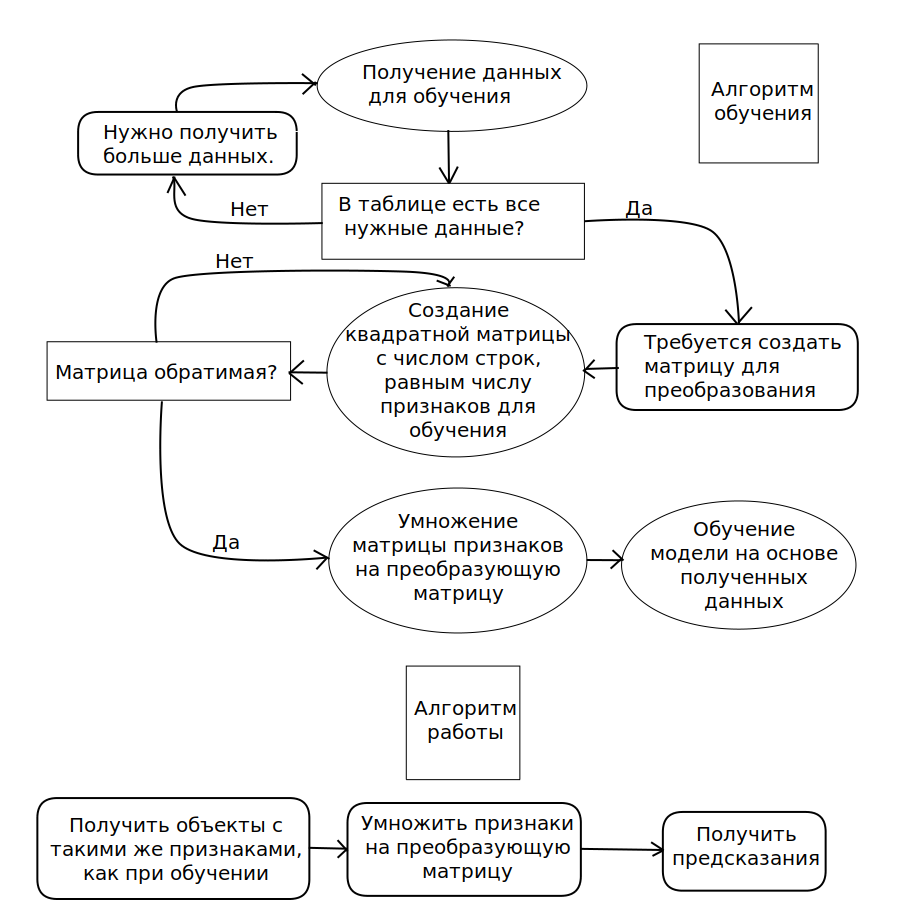

Если создать пару из двух обратных матриц, то можно умножить признаки на одну из них и использовать вторую в качестве ключа для получения исходных данных.

In [22]:
def get_rand_matrix():
    det = 0
    while det == 0:
        matrix = np.random.normal(size=(features.shape[1], features.shape[1]))
        det = np.linalg.det(matrix)
    return matrix
A = get_rand_matrix()
A

array([[-0.13105216, -0.2006461 , -1.69012289, -0.79441848],
       [ 1.52800166,  2.23640541, -2.61151195,  0.76600939],
       [ 1.74616801, -1.68913925, -0.26618848, -1.44891974],
       [-0.93826531, -0.07550096, -0.70175721, -0.16063802]])

In [23]:
A_inv = np.linalg.inv(A)
A_inv

array([[-0.44687662,  0.23647444,  0.36356486,  0.0583447 ],
       [ 3.57434848, -0.76252343, -1.79872547, -5.08858204],
       [ 1.34668722, -0.52493097, -0.7462739 , -2.43182951],
       [-4.95290828,  1.27036914,  1.98202326,  6.44930704]])

In [24]:
np.dot(A, A_inv)

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 3.55271368e-15,  1.00000000e+00, -1.33226763e-15,
        -1.77635684e-15],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-8.88178420e-16,  2.77555756e-16,  3.88578059e-16,
         1.00000000e+00]])

Погрешности возникают из-за того, что Python хранит ограниченное число знаков после запятой.

Вот как это выглядит для реальных данных:

In [25]:
features_new = np.dot(features, A)
features_new

array([[ 86671.51194447, -83689.89035268, -13312.41241067,
        -71835.96797909],
       [ 66423.73411286, -64084.49237316, -10235.99349528,
        -55023.87448204],
       [ 36713.84021494, -35407.06850476,  -5665.69189801,
        -30405.10035388],
       ...,
       [ 59223.77897175, -57217.24348743,  -9077.42317937,
        -49103.38041338],
       [ 57130.36404809, -55186.07972302,  -8765.611909  ,
        -47364.09975817],
       [ 70936.1358514 , -68516.71036801, -10882.76644755,
        -58805.64840422]])

In [26]:
np.dot(features_new, A_inv)

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [-5.82076609e-11,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [ 0.00000000e+00,  2.90000000e+01,  2.10000000e+04,
         2.91038305e-11],
       ...,
       [ 0.00000000e+00,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

In [27]:
features_back = pd.DataFrame(np.dot(features_new, A_inv).round().astype(int), 
                             columns=features.columns)

In [28]:
features_back

,Пол,Возраст,Зарплата,Члены семьи
0,1,41,49600,1
1,0,46,38000,1
2,0,29,21000,0
3,0,21,41700,2
4,1,28,26100,0
...,...,...,...,...
4995,0,28,35700,2
4996,0,34,52400,1
4997,0,20,33900,2
4998,1,22,32700,3


In [29]:
(features_back == features.round().astype(int)).sum()

Пол            5000
Возраст        5000
Зарплата       5000
Члены семьи    5000
dtype: int64

### Реализация

Опишем алгоритм преобразования функцией.

In [30]:
def transform_features(features):
    length = features.shape[1]
    determinant = 0
    while determinant == 0:
        matrix = np.random.normal(size=(length, length))
        determinant = np.linalg.det(matrix)
    matrix_inv = np.linalg.inv(matrix)
    features_transformed = pd.DataFrame(np.dot(features, matrix), 
                                        columns=features.columns, 
                                        index=features.index)
    return features_transformed, matrix_inv

### Тестирование

Посмотрим, изменится ли точность предсказания для таких признаков.

In [31]:
features.head()

,Пол,Возраст,Зарплата,Члены семьи
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0


In [32]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, random_state=57)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3750, 4)
(1250, 4)
(3750,)
(1250,)


In [33]:
test_LinearRegression(features_train, features_test, target_train, target_test)

0.4007021387970914

То же самое с изменёнными.

In [34]:
features_new, matrix_inv = transform_features(features)
features_new = pd.DataFrame(features_new, columns=features.columns, index=features.index)
features_new.head()

,Пол,Возраст,Зарплата,Члены семьи
0,31799.646425,55420.433989,7276.989275,57516.057474
1,24392.097980,42452.596726,5590.386862,44073.767191
2,13486.920708,23459.794411,3094.203954,24358.729360
3,26708.174474,46598.239652,6101.904360,48347.040414
4,16745.963062,29160.386049,3836.804744,30269.412427


In [35]:
matrix_inv

array([[-2.9775086 ,  0.18712483, -0.261403  ,  0.65182621],
       [-2.82835236, -0.36686428,  0.05637248,  0.32333677],
       [ 2.03389257,  0.31019515, -0.03835183, -0.76140484],
       [ 4.114201  ,  0.21150594,  0.95742692, -0.57558834]])

In [36]:
features_train, features_test, target_train, target_test = train_test_split(
    features_new, target, random_state=57)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3750, 4)
(1250, 4)
(3750,)
(1250,)


In [37]:
test_LinearRegression(features_train, features_test, target_train, target_test)

0.40070213879750083

Качество не упало.

## Выводы

1. Умножение на квадратную матрицу по алгоритму позволяет преобразовать данные.
2. Теоретически, качество линейной регрессии не должно при этом упасть.
3. По результатам тестирования до и после преобразования R2-метрика не поменялась.